# 원티드 프리온보딩 3주차 - 모두의 주차장

### 디지털 스킬셋 기술과제

주제
- 	앱 이용자 별 향후 이용 건수 예측

Value chain상 정의
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용

모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측

### Data 정의

Input: Tabular 데이터
- 	2020.01.01 ~ 2020.12-31 

Output: Regression (향후 이용 건수 예측)

Task 정의
- 	Regression, 유저 별 한 달 후 이용 건수 예측

Metric 정의
- 	MSE, MAE

데이터 수집
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터



In [22]:
!pip install pycaret

In [23]:
### 라이브러리 임포트
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')

In [24]:
import plaidml.keras
import os
plaidml.keras.install_backend ()
os.environ ['KERAS_BACKEND'] ='plaidml.keras.backend'


In [25]:
### 데이터 불러오기
# C:\Users\Bonghwan\Downloads\week3\modu
df = pd.read_csv('C:/Users/Bonghwan/Downloads/week3/modu/실전db.csv')
traffic = pd.read_excel('C:/Users/Bonghwan/Downloads/week3/modu/2020교통량통합.xlsx')
weather = pd.read_csv('C:/Users/Bonghwan/Downloads/week3/modu/서울시_기상데이터.csv', encoding='cp949')

df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [27]:
##컬럼별 데이터 확인
len(df['USER_ID'].unique()) # USER_ID : 165425 개
type(df['JOIN_DATE'].unique()[0]) # 가입일 : str

type(df['D_TYPE'][0]) # d_type : AA, BB, CC 그룹 분류, str
len(df['STORE_ID'].unique()) ## 1061 점포 갯수
df['GOODS_TYPE'].unique() ## 상품 타입(?) A, B, C, D 그룹 분류, str
type(df['DATE'][0]) # 날짜 : str
len(df['COUNT'].unique()) ## count : 61 개
len(df['AD1'].unique()) ## 85개

# np.random.seed(42)

85

In [28]:
from datetime import datetime
df['DATE']=df['DATE'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [29]:
df.groupby('D_TYPE')['COUNT'].value_counts()

D_TYPE  COUNT
AA      1        484275
        2          7801
        3           726
        4           183
        5            83
                  ...  
CC      53            1
        55            1
        58            1
        59            1
        61            1
Name: COUNT, Length: 88, dtype: int64

In [30]:
cdf = pd.DataFrame(df.groupby('D_TYPE')['COUNT'].value_counts())
cdf.rename(columns={'COUNT':'counts_식별용'}, inplace=True)
cdf = cdf.reset_index(level = [0,1]) 
cdf

,D_TYPE,COUNT,counts_식별용
0,AA,1,484275
1,AA,2,7801
2,AA,3,726
3,AA,4,183
4,AA,5,83
...,...,...,...
83,CC,53,1
84,CC,55,1
85,CC,58,1
86,CC,59,1


In [31]:
cdf[cdf['COUNT']==cdf['COUNT'].max()]
cdf[cdf['D_TYPE']=='AA']['COUNT'].max() # 23
cdf[cdf['D_TYPE']=='AA']['COUNT'].min() # 1
cdf[cdf['D_TYPE']=='BB']['COUNT'].max() # 19
cdf[cdf['D_TYPE']=='BB']['COUNT'].min() # 1
cdf[cdf['D_TYPE']=='CC']['COUNT'].max() # 61
cdf[cdf['D_TYPE']=='CC']['COUNT'].min() # 1

1

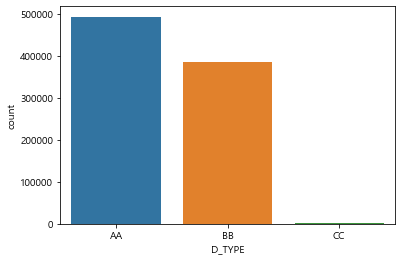

In [32]:
sns.countplot(data=df, x='D_TYPE')

### D_TYPE은 
1. AA 그룹에서 1~23
2. BB 그룹에서 1~19
3. CC 그룹에서 1~61
의 범위를 가짐

C 그룹의 결제건수가 확연히 적음

In [33]:
adf = df.query("D_TYPE == 'AA'")
bdf = df.query("D_TYPE == 'BB'")
cdf = df.query("D_TYPE == 'CC'")

In [34]:
adf.query('GOODS_TYPE == "A"') # 345779 
adf.query('GOODS_TYPE == "B"') #  65966
adf.query('GOODS_TYPE == "C"') #  70010

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
14,88589,2015-05-18,AA,2334,C,2020-01-01,1,MP
16,118732,2015-07-03,AA,220690,C,2020-01-01,1,GN
20,138118,2015-08-09,AA,102276,C,2020-01-01,1,SC
25,175466,2015-10-10,AA,82408,C,2020-01-01,1,GSN
...,...,...,...,...,...,...,...,...
879213,1829862,2020-12-31,AA,109877,C,2020-12-31,1,GN
879226,1829935,2020-12-31,AA,220893,C,2020-12-31,1,J
879231,1829962,2020-12-31,AA,220689,C,2020-12-31,1,GN
879236,1830033,2020-12-31,AA,109050,C,2020-12-31,1,GJ


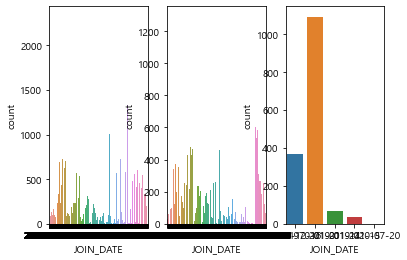

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1)
sns.countplot(data=adf, x='JOIN_DATE', ax=ax1)
sns.countplot(data=bdf, x='JOIN_DATE', ax=ax2)
sns.countplot(data=cdf, x='JOIN_DATE', ax=ax3)


In [36]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df.groupby('AD1')['COUNT'].value_counts()
df.query('AD1 == "ZE"')['COUNT'].max()
ad = df["AD1"].tolist()
encoder.fit(ad)
ad = encoder.transform(ad)
len(list(set(ad)))


85

In [37]:
gdf = pd.DataFrame(df.groupby('GOODS_TYPE')['COUNT'].value_counts())
gdf.rename(columns={'COUNT':'counts_식별용'}, inplace=True)
gdf = gdf.reset_index(level = [0,1]) 
gdf

,GOODS_TYPE,COUNT,counts_식별용
0,A,1,599452
1,A,2,8823
2,A,3,798
3,A,4,205
4,A,5,108
...,...,...,...
113,D,11,1
114,D,15,1
115,D,23,1
116,D,26,1


In [38]:
gdf.query('GOODS_TYPE =="A"')['COUNT'].max() # 61
gdf.query('GOODS_TYPE =="A"')['COUNT'].min() # 1
gdf.query('GOODS_TYPE =="B"')['COUNT'].max() # 23
gdf.query('GOODS_TYPE =="B"')['COUNT'].min() # 1
gdf.query('GOODS_TYPE =="C"')['COUNT'].max() # 49
gdf.query('GOODS_TYPE =="C"')['COUNT'].min() # 1
gdf.query('GOODS_TYPE =="D"')['COUNT'].max() # 40
gdf.query('GOODS_TYPE =="D"')['COUNT'].min() # 1
print('A 그룹 : {},\t B 그룹 : {} \t, C 그룹 : {} \t, D 그룹 : {}  \t'.format(len(df.query('GOODS_TYPE =="A"')), len(df.query('GOODS_TYPE =="B"')), len(df.query('GOODS_TYPE =="C"')), len(df.query('GOODS_TYPE =="D"'))))

A 그룹 : 609790,	 B 그룹 : 118541 	, C 그룹 : 131163 	, D 그룹 : 19777  	


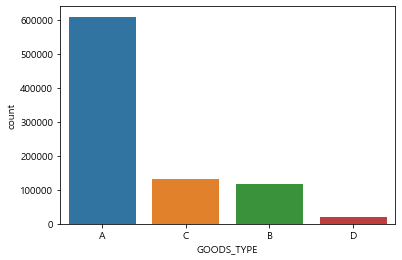

In [39]:
sns.countplot(data=df, x='GOODS_TYPE')

GOODS_TYPE은

1. A 그룹에서 1~61
2. B 그룹에서 1~23
3. C 그룹에서 1~49
4. D 그룹에서 1~40 의 범위를 가짐

A 그룹이 결제 건수가 압도적으로 높고, D 그룹의 결제 건수는 확연히 적음

In [40]:
encoder.fit(df["AD1"])
df["AD1"] = encoder.transform(df["AD1"])
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,40
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,50
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,64
3,37001,2014-12-04,BB,725,C,2020-01-01,1,53
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,52
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,40
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,19
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,52
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,50


In [41]:
encoder.fit(df["GOODS_TYPE"])
df["GOODS_TYPE"] = encoder.transform(df["GOODS_TYPE"])
encoder.fit(df["D_TYPE"])
df["D_TYPE"] = encoder.transform(df["D_TYPE"])
encoder.fit(df["DATE"])
df["date_int"] = encoder.transform(df["DATE"])
encoder.fit(df["JOIN_DATE"])
df["join_date_int"] = encoder.transform(df["JOIN_DATE"])

df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int
0,2858,2014-01-07,0,1892,0,2020-01-01,1,40,0,8
1,5647,2014-02-14,1,182009,0,2020-01-01,1,50,0,17
2,33314,2014-11-20,1,82431,0,2020-01-01,1,64,0,119
3,37001,2014-12-04,1,725,2,2020-01-01,1,53,0,133
4,37819,2014-12-07,0,220691,2,2020-01-01,1,52,0,136
...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,1,219886,1,2020-12-31,1,40,365,2351
879267,1830570,2020-12-31,1,82433,1,2020-12-31,1,19,365,2351
879268,1830580,2020-12-31,0,92020,1,2020-12-31,1,52,365,2351
879269,1830589,2020-12-31,1,92437,1,2020-12-31,1,50,365,2351


### STORE_ID별


<Figure size 1152x720 with 0 Axes>

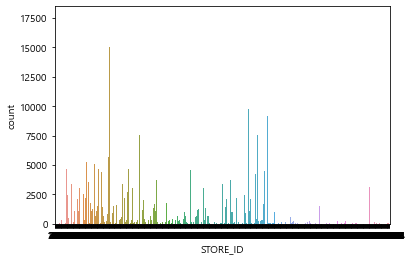

<Figure size 1152x720 with 0 Axes>

In [42]:
sns.countplot(data=df, x='STORE_ID')
plt.figure(figsize=(16,10))

In [43]:
sdf = pd.DataFrame(df.groupby('STORE_ID')['COUNT'].sum())
sdf.reset_index(level=[0], inplace=True)
sdf.sort_values('COUNT', ascending=False, inplace=True)
sdf

,STORE_ID,COUNT
514,220557,17854
612,220893,17653
533,220655,16815
142,92437,16495
603,220848,16298
...,...,...
931,230196,1
927,230190,1
464,220018,1
923,228955,1


In [44]:
slist = sdf.sort_values('COUNT', ascending=False)['STORE_ID'][:10].tolist()
clist = sdf.sort_values('COUNT', ascending=False)['COUNT'][:10].tolist()
slist
clist

[17854, 17653, 16815, 16495, 16298, 15395, 14850, 14612, 12524, 12450]

STORE_ID별 편차가 큼.

In [45]:
df.groupby('USER_ID')['COUNT'].count().max()
# df[df['USER_ID']==232]
df.query('COUNT == COUNT.max()')
df[df['USER_ID'] == 999665]
# df[df['USER_ID'] == 999665]['COUNT'].sum()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int
372,999665,2018-12-16,2,82399,0,2020-01-01,6,52,0,1605
1527,999665,2018-12-16,2,104988,0,2020-01-02,11,40,1,1605
3121,999665,2018-12-16,2,181832,0,2020-01-03,7,64,2,1605
5034,999665,2018-12-16,2,109223,0,2020-01-04,28,53,3,1605
6919,999665,2018-12-16,2,104916,0,2020-01-05,14,40,4,1605
...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,2,2428,0,2020-12-27,17,19,361,1605
868847,999665,2018-12-16,2,109267,0,2020-12-28,24,50,362,1605
871562,999665,2018-12-16,2,90193,2,2020-12-29,23,46,363,1605
874317,999665,2018-12-16,2,220797,3,2020-12-30,40,43,364,1605


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   USER_ID        879271 non-null  int64         
 1   JOIN_DATE      879271 non-null  object        
 2   D_TYPE         879271 non-null  int32         
 3   STORE_ID       879271 non-null  int64         
 4   GOODS_TYPE     879271 non-null  int32         
 5   DATE           879271 non-null  datetime64[ns]
 6   COUNT          879271 non-null  int64         
 7   AD1            879271 non-null  int32         
 8   date_int       879271 non-null  int64         
 9   join_date_int  879271 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(4), object(1)
memory usage: 53.7+ MB


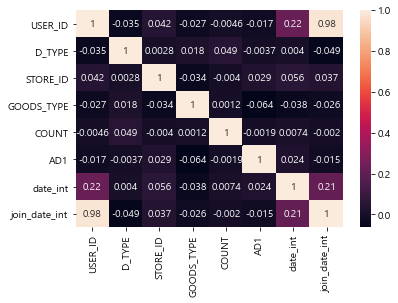

In [47]:
sns.heatmap(df.corr(), annot=True)

사실상 이 히트맵에서는 상관관계는 없다고 보는 게 맞을 듯....
유저 아이디와 회원가입일의 경우는 유저 아이디에 따라 계속해서 반복되기 때문에, 상관관계가 높은 것으로 나옴.


In [48]:
weather

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


 ### *강수량과 적설량의 차이*

 “예보관들이 적설량을 관측할 때 쌓여있는 눈이 몇 ㎝인지 잰다”며 “하지만 눈이 내린 전체 양을 기록하기 위해서는 관측할 때 쌓여 있는 눈 외에 이미 녹은 양도 포함해 기록해야 하기 때문에 강수량인 ㎜로도 표기하는 것”

In [49]:
type(weather['일시'][0])

str

In [50]:
weather[weather['일조시간']>0]
weather.isnull().sum()
weather.fillna(0, inplace=True)
weather['is_rainy'] = weather['강수량'].apply(lambda x: 1 if x > 0 else 0) 
# weather['is_snow'] = weather['적설량'].apply(lambda x: 1 if x > 0 else 0) 
## 시간을 3시간 단위로?
# weather[weather['일시'][:10] == '2020-01-01']
# weather['일시'][0][:10]
weather['DATE']= weather['일시'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d'))
weather.groupby('DATE')['기온'].sum()/weather.groupby('DATE')['기온'].count()
# weather.drop('일조시간',axis=1)

DATE
2020-01-01    -2.543478
2020-01-02     0.987500
2020-01-03     0.120833
2020-01-04     1.054167
2020-01-05     1.175000
                ...    
2020-12-27     5.395833
2020-12-28     6.920833
2020-12-29     1.033333
2020-12-30   -10.366667
2020-12-31   -12.700000
Name: 기온, Length: 366, dtype: float64

### 2020 공휴일

날짜	요일	공휴일   
1월 1일	수요일	새해  
1월 24일 ~ 1월 26일	금요일 ~ 일요일	설날  
3월 1일	일요일	3·1 운동/삼일절  
4월 30일	목요일	부처님 오신 날  
5월 5일	화요일	어린이날  
6월 6일	토요일	현충일  
8월 15일	토요일	광복절  
8월 17일	월요일	광복절 휴일  
9월 30일 ~ 10월 2일	수요일 ~ 금요일	추석  
10월 3일	토요일	개천절  
10월 9일	금요일	한글날  
12월 25일	금요일	크리스마스  



In [51]:
df.sort_values('COUNT', ascending=False, inplace=True)
# df.groupby("STORE_ID")['COUNT'].value_counts()

### 날짜별 분석


In [52]:
df['day'] = [k for k in df['DATE'].dt.dayofweek] ## 요일 칼럼
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3
...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2


In [53]:
df['is_weekend'] = df['day'].apply(lambda x: 1 if x > 4 else 0)
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0


In [54]:
h_list = ['2020-01-01', '2020-01-24', '2020-01-25','2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15','2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']
hol_list =[]
for i in h_list:
  hol = datetime.date(datetime.strptime(i, '%Y-%m-%d'))
  print(hol)
  hol_list.append(hol)
hol_list

2020-01-01
2020-01-24
2020-01-25
2020-01-26
2020-03-01
2020-04-30
2020-05-05
2020-06-06
2020-08-15
2020-08-17
2020-09-30
2020-10-01
2020-10-02
2020-10-03
2020-10-09
2020-12-25


[datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 6, 6),
 datetime.date(2020, 8, 15),
 datetime.date(2020, 8, 17),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 10, 2),
 datetime.date(2020, 10, 3),
 datetime.date(2020, 10, 9),
 datetime.date(2020, 12, 25)]

In [55]:
df['is_holiday'] = df['DATE'].apply(lambda x: 1 if x in hol_list else 0)

In [56]:
df.query('is_holiday == 1')['COUNT'].sum()/df.query('is_holiday == 1')['COUNT'].count()

1.0331672248999264

In [57]:
df.query('is_holiday == 0')['COUNT'].sum()/df.query('is_holiday == 0')['COUNT'].count()

1.0289615331970814

In [58]:
df.query('is_weekend == 1')['COUNT'].sum()/df.query('is_weekend == 1')['COUNT'].count()

1.033024067609774

In [59]:
df.query('is_weekend == 0')['COUNT'].sum()/df.query('is_weekend == 0')['COUNT'].count()

1.027780171143268

In [60]:
df.query('is_weekend == 0 and is_holiday == 0')['COUNT'].sum()/df.query('is_weekend == 0 and is_holiday == 0')['COUNT'].count()

1.0276775230542892

In [61]:
df.query('is_weekend == 0 and is_holiday == 1')['COUNT'].sum()/df.query('is_weekend == 0 and is_holiday == 1')['COUNT'].count()

1.0321621978602562

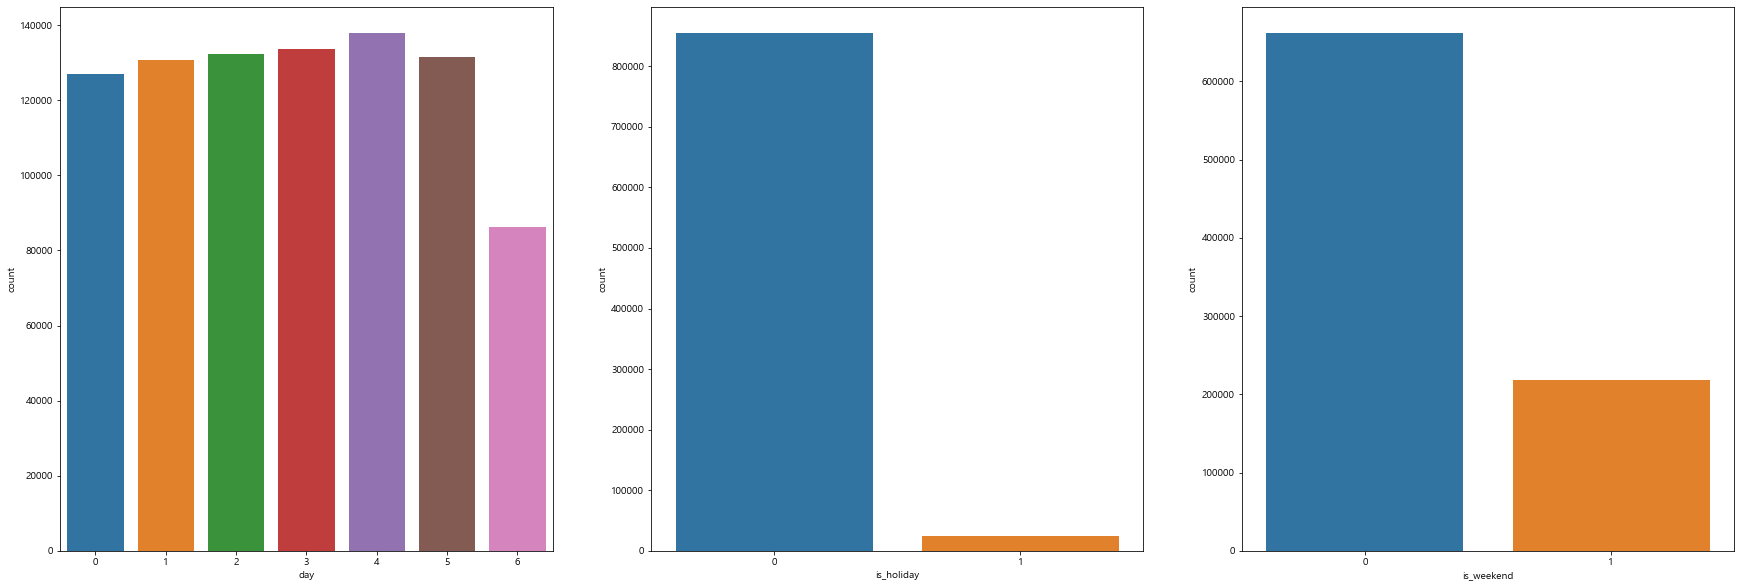

In [62]:
df.groupby('day')['COUNT'].sum()
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 10)
# sns.barplot(data = df.groupby('day')['COUNT'].sum(), x = 'day')
sns.countplot(data=df, x='day', ax = ax1)
sns.countplot(data=df, x='is_holiday', ax = ax2)
sns.countplot(data=df, x='is_weekend', ax = ax3)

주말, 특히 일요일의 경우 결제 건수가 확연히 줄어드는 것을 볼 수 있고,
주말인 경우와 공휴일의 경우 절대적인 날짜의 차이가 있기때문에, 차이를 볼 수 있지만, 날짜 대비 결제 건수는 주말과 공휴일에 늘어나는 것을 볼 수 있다.


In [63]:
df['month']=df['DATE'].dt.month
df['week']=df['DATE'].dt.week
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0,0,11,46
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1,0,11,46
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0,0,11,45
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0,0,11,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0,0,5,22
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0,0,5,22
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0,0,5,22
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0,0,5,22


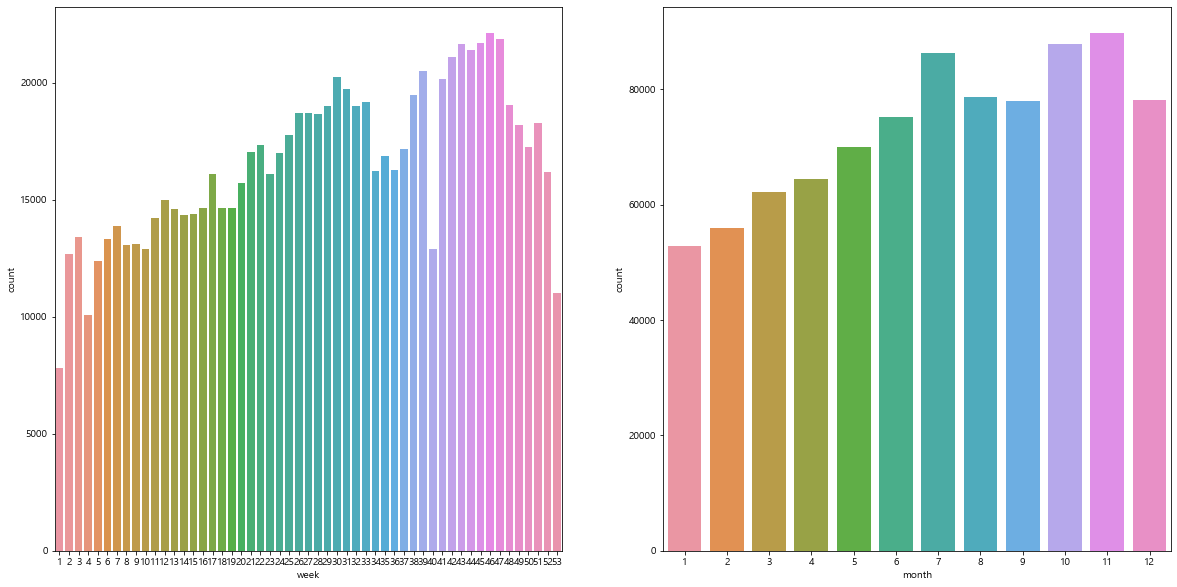

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,10)
sns.countplot(data=df, x='week', ax=ax1)
sns.countplot(data=df, x='month', ax=ax2)

In [65]:
df.query('week == 41')['COUNT'].sum() # 20816
df.query('week == 40')['COUNT'].sum() # 13329
df.query('week == 40') ## 추석이 있는 주
df.query('week == 34') ## 광복절, 대체연휴가 있는 주

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
517910,999665,2018-12-16,2,105274,2,2020-08-20,31,19,232,1605,3,0,0,8,34
515223,999665,2018-12-16,2,221018,0,2020-08-19,24,53,231,1605,2,0,0,8,34
520614,999665,2018-12-16,2,219891,0,2020-08-21,22,83,233,1605,4,0,0,8,34
512451,999665,2018-12-16,2,90193,2,2020-08-18,22,46,230,1605,1,0,0,8,34
510288,999665,2018-12-16,2,220893,0,2020-08-17,21,50,229,1605,0,0,1,8,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517311,428194,2016-12-13,0,109422,0,2020-08-20,1,50,232,872,3,0,0,8,34
517312,428836,2016-12-14,0,96266,0,2020-08-20,1,40,232,873,3,0,0,8,34
517313,429225,2016-12-14,1,109421,0,2020-08-20,1,50,232,873,3,0,0,8,34
517314,431298,2016-12-18,0,220848,1,2020-08-20,1,40,232,877,3,0,0,8,34


### 월별로 보면 주로 겨울에 비해 여름과 특히 가을에 사용량이 비교적 많은 편
### 주차별로 확인 할 경우, 연초와 연말 그리고 추석이 있는 주 차에서 이용량이 급감

---
## AD1 별

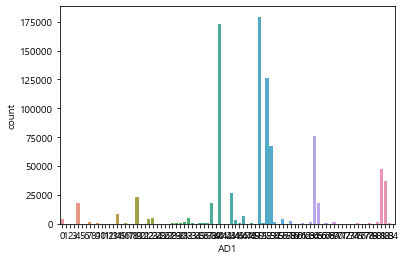

In [66]:
sns.countplot(data=df, x='AD1')

<Figure size 1152x720 with 0 Axes>

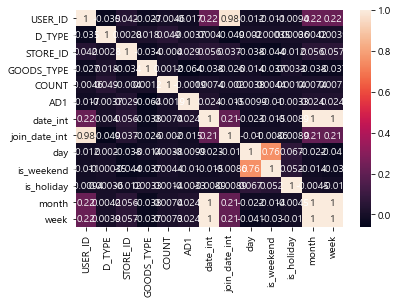

<Figure size 1152x720 with 0 Axes>

In [67]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), annot=True)
# fig.figure(figsi)
plt.figure(figsize=(16,10))

In [68]:
df.corr().query('COUNT > 0.3 or COUNT < -0.3')

,USER_ID,D_TYPE,STORE_ID,GOODS_TYPE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
COUNT,-0.004571,0.049195,-0.004013,0.001226,1.0,-0.001853,0.007376,-0.001977,0.003786,0.004417,0.00135,0.007357,0.0073


In [69]:
df.groupby('AD1')['COUNT'].value_counts()
df.groupby('AD1')['COUNT'].sum().sort_values(ascending=False)

AD1
50    184660
40    178190
52    130476
64     78176
53     69277
       ...  
71         3
72         1
55         1
2          1
42         1
Name: COUNT, Length: 85, dtype: int64

AD1 별로 결제 건수의 편차가 심함.

In [70]:
df[df["COUNT"]> 10]['USER_ID'].unique()

array([ 999665, 1635143, 1467323, 1544719, 1775410, 1675755, 1599008,
       1660735, 1675314, 1572434, 1304663, 1613793,  709657, 1407822,
       1514190,  430741], dtype=int64)

In [71]:
## 지점은 108으로 동일
weather.drop('지점', axis=1, inplace=True)
## 풍속과는 연관이 있을까?

In [72]:
# weather['일시'][0][:10]
weather['DATE'] = weather['일시']
weather['DATE'] = weather['DATE'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d'))
wdf = pd.merge(df, weather, on='DATE')
wdf


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,...,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,is_rainy
0,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,...,2020-11-07 0:00,14.3,0.0,1.3,78,0.0,0.0,12.1,13.1,0
1,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,...,2020-11-07 1:00,14.6,0.0,2.3,83,0.0,0.0,12.4,13.1,0
2,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,...,2020-11-07 2:00,14.5,0.0,1.5,84,0.0,0.0,12.4,13.1,0
3,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,...,2020-11-07 3:00,14.4,0.0,1.8,87,0.0,0.0,12.3,13.1,0
4,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,...,2020-11-07 4:00,14.4,0.0,2.1,89,0.0,0.0,12.4,13.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039130,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,...,2020-02-18 19:00,-1.6,0.0,1.5,47,0.0,0.0,0.1,3.7,0
21039131,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,...,2020-02-18 20:00,-2.3,0.0,1.6,49,0.0,0.0,-0.5,3.6,0
21039132,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,...,2020-02-18 21:00,-2.7,0.0,2.0,50,0.0,0.0,-0.7,3.7,0
21039133,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,...,2020-02-18 22:00,-3.2,0.0,0.7,51,0.0,0.0,-0.9,3.7,0


In [73]:
### 날씨, 요일별 표시를 위해 평균값으로 설정.
weather_group_df = pd.DataFrame(weather.groupby('DATE').mean())
weather_group_df.reset_index(level=0, inplace=True)
# weather_group_df.drop('지점', axis=1, inplace=True)
weather_group_df.drop('풍속', axis=1, inplace=True)
weather_group_df.drop('습도', axis=1, inplace=True)
weather_group_df.drop('일조시간', axis=1, inplace=True)
weather_group_df.drop('지면온도', axis=1, inplace=True)
weather_group_df.drop('지중온도', axis=1, inplace=True)
weather_group_df

,DATE,기온,강수량,적설량,is_rainy
0,2020-01-01,-2.543478,0.004348,0.0,0.043478
1,2020-01-02,0.987500,0.000000,0.0,0.000000
2,2020-01-03,0.120833,0.000000,0.0,0.000000
3,2020-01-04,1.054167,0.000000,0.0,0.000000
4,2020-01-05,1.175000,0.000000,0.0,0.000000
...,...,...,...,...,...
361,2020-12-27,5.395833,0.000000,0.0,0.000000
362,2020-12-28,6.920833,0.054167,0.0,0.041667
363,2020-12-29,1.033333,0.008333,0.0,0.041667
364,2020-12-30,-10.366667,0.000000,0.0,0.000000


In [74]:
weather_group_df.query('적설량 > 0')

,DATE,기온,강수량,적설량,is_rainy
18,2020-01-19,1.816667,0.025000,0.012500,0.041667
34,2020-02-04,-1.416667,0.070833,0.129167,0.083333
35,2020-02-05,-7.954167,0.000000,0.291667,0.000000
46,2020-02-16,-0.570833,0.629167,1.762500,0.250000
47,2020-02-17,-5.641667,0.041667,3.187500,0.083333
48,2020-02-18,-4.275000,0.000000,1.037500,0.000000
347,2020-12-13,-0.441667,0.120833,1.520833,0.166667
348,2020-12-14,-7.450000,0.000000,1.295833,0.000000
349,2020-12-15,-8.266667,0.000000,0.929167,0.000000
350,2020-12-16,-8.200000,0.000000,0.741667,0.000000


In [75]:
weather[weather['DATE']=='2020-02-04']

,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,is_rainy,DATE
815,2020-02-04 0:00,-2.9,0.0,1.8,40,0.0,0.0,-2.0,4.2,0,2020-02-04
816,2020-02-04 1:00,-3.5,0.0,1.0,43,0.0,0.0,-2.4,4.1,0,2020-02-04
817,2020-02-04 2:00,-3.7,0.0,2.2,37,0.0,0.0,-2.7,4.0,0,2020-02-04
818,2020-02-04 3:00,-4.3,0.0,1.7,38,0.0,0.0,-3.1,4.0,0,2020-02-04
819,2020-02-04 4:00,-4.8,0.0,1.0,37,0.0,0.0,-3.5,3.9,0,2020-02-04
820,2020-02-04 5:00,-5.2,0.0,0.8,42,0.0,0.0,-4.0,3.9,0,2020-02-04
821,2020-02-04 6:00,-5.7,0.0,1.4,45,0.0,0.0,-4.2,3.8,0,2020-02-04
822,2020-02-04 7:00,-6.0,0.0,1.8,43,0.0,0.0,-4.3,3.6,0,2020-02-04
823,2020-02-04 8:00,-5.8,0.0,1.3,40,0.1,0.0,-4.0,3.6,0,2020-02-04
824,2020-02-04 9:00,-4.3,0.0,2.5,39,1.0,0.0,-2.8,3.5,0,2020-02-04


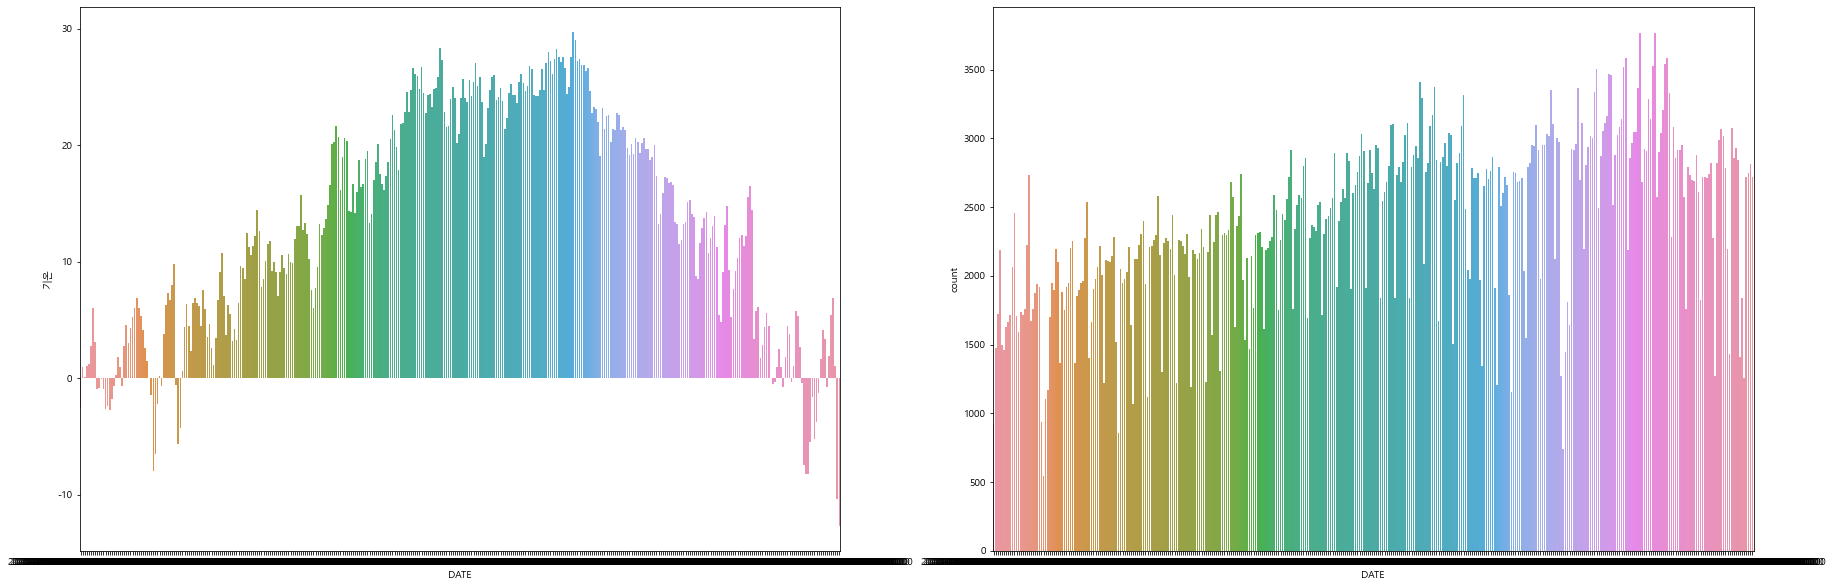

In [76]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30,10)
sns.barplot(data=weather_group_df, x='DATE', y='기온', ax=ax1)
sns.countplot(data=df, x='DATE', ax=ax2)

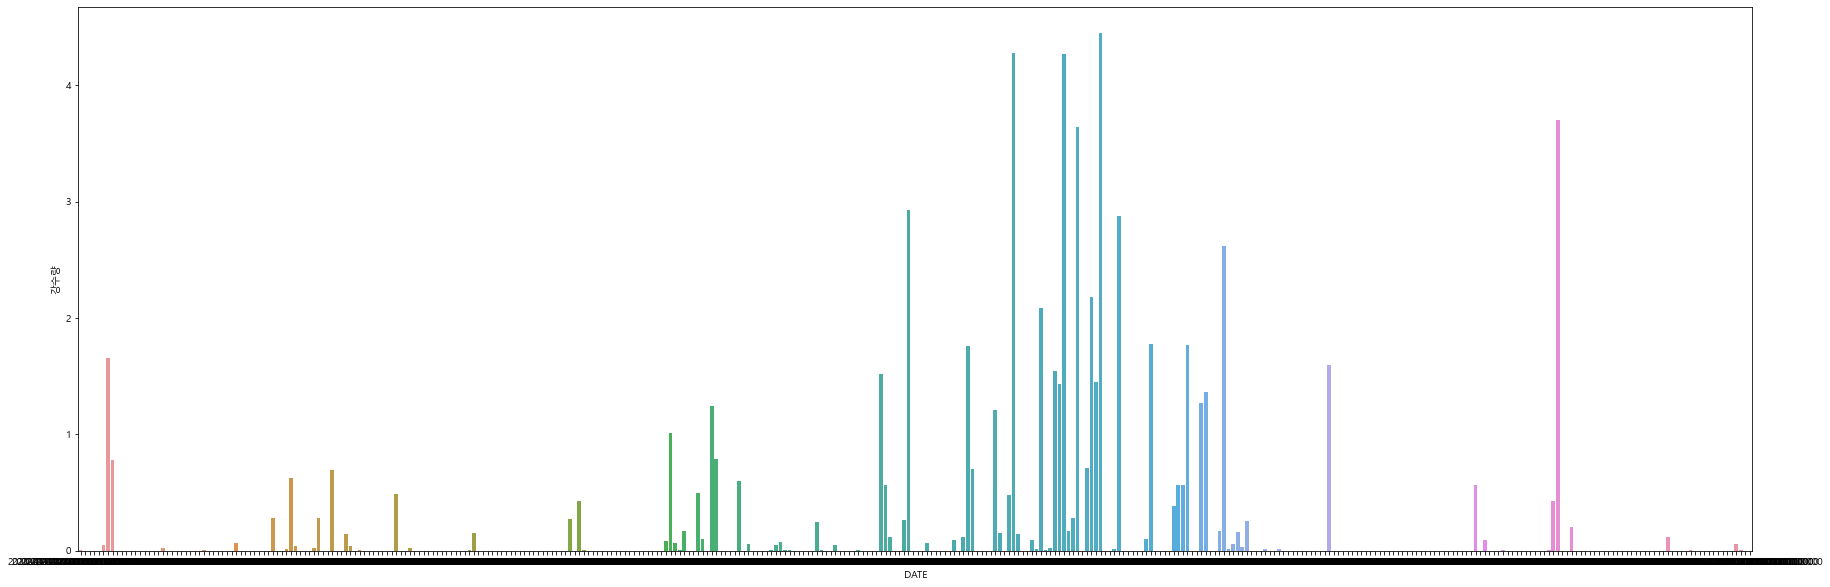

In [77]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(30,10)
sns.barplot(data=weather_group_df, x='DATE', y='강수량', ax=ax1)


In [78]:
df.COUNT.describe()
## 데이터 이상치
## 61 COUNT 
df[df['COUNT']== df['COUNT'].max()] ## 999665
df[df['USER_ID']==999665]['COUNT'].sum() ## 7919
df[df['USER_ID']==999665]['COUNT']
df.query('COUNT > 10 and USER_ID != 999665')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
476895,1635143,2020-07-24,0,221045,0,2020-08-04,23,40,216,2191,1,0,0,8,32
419592,1467323,2020-01-11,0,220836,1,2020-07-15,23,52,196,1996,2,0,0,7,29
372116,1467323,2020-01-11,0,220836,0,2020-06-27,22,52,178,1996,5,1,0,6,26
31925,1467323,2020-01-11,0,220836,0,2020-01-18,20,52,17,1996,5,1,0,1,3
208433,1544719,2020-04-17,1,221045,0,2020-04-18,19,40,108,2093,5,1,0,4,16
757192,1775410,2020-11-14,1,92505,0,2020-11-15,17,50,319,2304,6,1,0,11,46
604384,1675755,2020-09-02,0,219913,0,2020-09-23,15,40,266,2231,2,0,0,9,39
734271,1599008,2020-06-17,1,203847,0,2020-11-08,15,64,312,2154,6,1,0,11,45
866365,1660735,2020-08-18,1,90444,0,2020-12-26,15,40,360,2216,5,1,0,12,52
618893,1675314,2020-09-01,1,109670,0,2020-09-28,15,19,271,2230,0,0,0,9,40


In [79]:
df.sort_values('COUNT', ascending=False)['USER_ID'].unique()[:10]
# df[df['USER_ID']==1775410]
df[df['COUNT']>10]["USER_ID"].unique() # 16 개
df[df['COUNT']<10]
df[df['COUNT']>10]
# df['COUNT'].describe()


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0,0,11,46
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1,0,11,46
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0,0,11,45
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0,0,11,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460594,430741,2016-12-17,1,219913,0,2020-07-30,11,40,211,876,3,0,0,7,31
196056,999665,2018-12-16,2,1900,2,2020-04-13,11,40,103,1605,0,0,0,4,16
220105,999665,2018-12-16,2,1109,0,2020-04-24,11,52,114,1605,4,0,0,4,17
775274,1467323,2020-01-11,0,220836,0,2020-11-21,11,52,325,1996,5,1,0,11,47


In [80]:
# ## 최소 시간이 3시간 권이므로, COUNT 가 8 이상인 경우 이상치로 판단하고 드랍
#### -> 최소시간 30 분, 추가적으로 법인(?)사용 가능성 있으므로 드랍하지 않음.
# ano_list = df[df['COUNT']>8]["USER_ID"].unique().tolist()
# df = df[~df['USER_ID'].isin(ano_list)]
# df

In [81]:
weather_group_df['is_rainy'] = weather_group_df['is_rainy'].apply(lambda x: 1 if x>0 else 0)
weather_group_df

,DATE,기온,강수량,적설량,is_rainy
0,2020-01-01,-2.543478,0.004348,0.0,1
1,2020-01-02,0.987500,0.000000,0.0,0
2,2020-01-03,0.120833,0.000000,0.0,0
3,2020-01-04,1.054167,0.000000,0.0,0
4,2020-01-05,1.175000,0.000000,0.0,0
...,...,...,...,...,...
361,2020-12-27,5.395833,0.000000,0.0,0
362,2020-12-28,6.920833,0.054167,0.0,1
363,2020-12-29,1.033333,0.008333,0.0,1
364,2020-12-30,-10.366667,0.000000,0.0,0


In [82]:
merged_df = pd.merge(df, weather_group_df, on='DATE')
merged_df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week,기온,강수량,적설량,is_rainy
0,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,14.795833,0.004167,0.0000,1
1,1181646,2019-05-30,1,182296,0,2020-11-07,9,64,311,1770,5,1,0,11,45,14.795833,0.004167,0.0000,1
2,271912,2016-03-26,1,109670,0,2020-11-07,6,19,311,610,5,1,0,11,45,14.795833,0.004167,0.0000,1
3,1695983,2020-09-19,0,222410,0,2020-11-07,6,50,311,2248,5,1,0,11,45,14.795833,0.004167,0.0000,1
4,1617426,2020-07-05,0,228953,0,2020-11-07,5,64,311,2172,5,1,0,11,45,14.795833,0.004167,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1485659,2020-02-01,1,207620,1,2020-02-18,1,40,48,2017,1,0,0,2,8,-4.275000,0.000000,1.0375,0
879267,1485722,2020-02-01,1,220655,1,2020-02-18,1,52,48,2017,1,0,0,2,8,-4.275000,0.000000,1.0375,0
879268,1486580,2020-02-02,1,220893,0,2020-02-18,1,50,48,2018,1,0,0,2,8,-4.275000,0.000000,1.0375,0
879269,1486875,2020-02-02,1,207620,1,2020-02-18,1,40,48,2018,1,0,0,2,8,-4.275000,0.000000,1.0375,0


In [83]:
merged_df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week,기온,강수량,적설량,is_rainy
0,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,14.795833,0.004167,0.0000,1
1,1181646,2019-05-30,1,182296,0,2020-11-07,9,64,311,1770,5,1,0,11,45,14.795833,0.004167,0.0000,1
2,271912,2016-03-26,1,109670,0,2020-11-07,6,19,311,610,5,1,0,11,45,14.795833,0.004167,0.0000,1
3,1695983,2020-09-19,0,222410,0,2020-11-07,6,50,311,2248,5,1,0,11,45,14.795833,0.004167,0.0000,1
4,1617426,2020-07-05,0,228953,0,2020-11-07,5,64,311,2172,5,1,0,11,45,14.795833,0.004167,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1485659,2020-02-01,1,207620,1,2020-02-18,1,40,48,2017,1,0,0,2,8,-4.275000,0.000000,1.0375,0
879267,1485722,2020-02-01,1,220655,1,2020-02-18,1,52,48,2017,1,0,0,2,8,-4.275000,0.000000,1.0375,0
879268,1486580,2020-02-02,1,220893,0,2020-02-18,1,50,48,2018,1,0,0,2,8,-4.275000,0.000000,1.0375,0
879269,1486875,2020-02-02,1,207620,1,2020-02-18,1,40,48,2018,1,0,0,2,8,-4.275000,0.000000,1.0375,0


### JOIN DATE 처리 여부

In [84]:
merged_df.sort_values('JOIN_DATE')
merged_df.query("JOIN_DATE == '1970-01-01'")

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week,기온,강수량,적설량,is_rainy
41,859401,1970-01-01,2,104067,0,2020-11-07,2,53,311,0,5,1,0,11,45,14.795833,0.004167,0.0000,1
208,394897,1970-01-01,2,82431,0,2020-11-07,1,64,311,0,5,1,0,11,45,14.795833,0.004167,0.0000,1
1581,1763312,1970-01-01,2,220074,2,2020-11-07,1,53,311,0,5,1,0,11,45,14.795833,0.004167,0.0000,1
1583,1763317,1970-01-01,2,220897,0,2020-11-07,1,50,311,0,5,1,0,11,45,14.795833,0.004167,0.0000,1
4094,1641479,1970-01-01,2,82407,0,2020-11-13,1,40,317,0,4,0,0,11,46,12.054167,0.000000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877950,1230331,1970-01-01,2,220721,0,2020-02-18,1,4,48,0,1,0,0,2,8,-4.275000,0.000000,1.0375,0
878133,1355917,1970-01-01,2,104905,0,2020-02-18,1,40,48,0,1,0,0,2,8,-4.275000,0.000000,1.0375,0
878202,1363699,1970-01-01,2,105301,0,2020-02-18,1,53,48,0,1,0,0,2,8,-4.275000,0.000000,1.0375,0
878974,1410151,1970-01-01,2,92437,1,2020-02-18,1,50,48,0,1,0,0,2,8,-4.275000,0.000000,1.0375,0


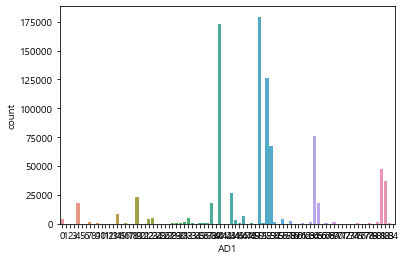

In [85]:
# df = df.sort_values('COUNT')
sns.countplot(data=df, x="AD1")

In [86]:
df[df['D_TYPE']==2].count()
df[df['is_weekend']==1].count()
df.query('GOODS_TYPE == 0 and is_weekend == 0') # 443327
df.query('GOODS_TYPE == 1 and is_weekend == 0') # 109883
df.query('GOODS_TYPE == 2 and is_weekend == 0') # 90606
df.query('GOODS_TYPE == 3 and is_weekend == 0') # 90606

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
874317,999665,2018-12-16,2,220797,3,2020-12-30,40,43,364,1605,2,0,0,12,53
424410,999665,2018-12-16,2,220578,3,2020-07-17,29,40,198,1605,4,0,0,7,29
701903,999665,2018-12-16,2,1109,3,2020-10-29,29,52,302,1605,3,0,0,10,44
480972,999665,2018-12-16,2,220797,3,2020-08-06,26,43,218,1605,3,0,0,8,32
493874,999665,2018-12-16,2,183093,3,2020-08-11,25,43,223,1605,1,0,0,8,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295548,1579656,2020-05-27,0,183093,3,2020-05-27,1,43,147,2133,2,0,0,5,22
295435,1575054,2020-05-22,1,91853,3,2020-05-27,1,81,147,2128,2,0,0,5,22
295512,1579385,2020-05-27,1,222357,3,2020-05-27,1,64,147,2133,2,0,0,5,22
295518,1579404,2020-05-27,0,220557,3,2020-05-27,1,82,147,2133,2,0,0,5,22


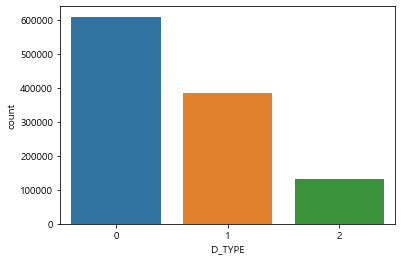

In [87]:
sns.countplot(data=df, x='GOODS_TYPE')
sns.countplot(data=df, x='D_TYPE')

In [88]:
adtype = df[df['D_TYPE']==0]
bdtype = df[df['D_TYPE']==1]
cdtype = df[df['D_TYPE']==2]

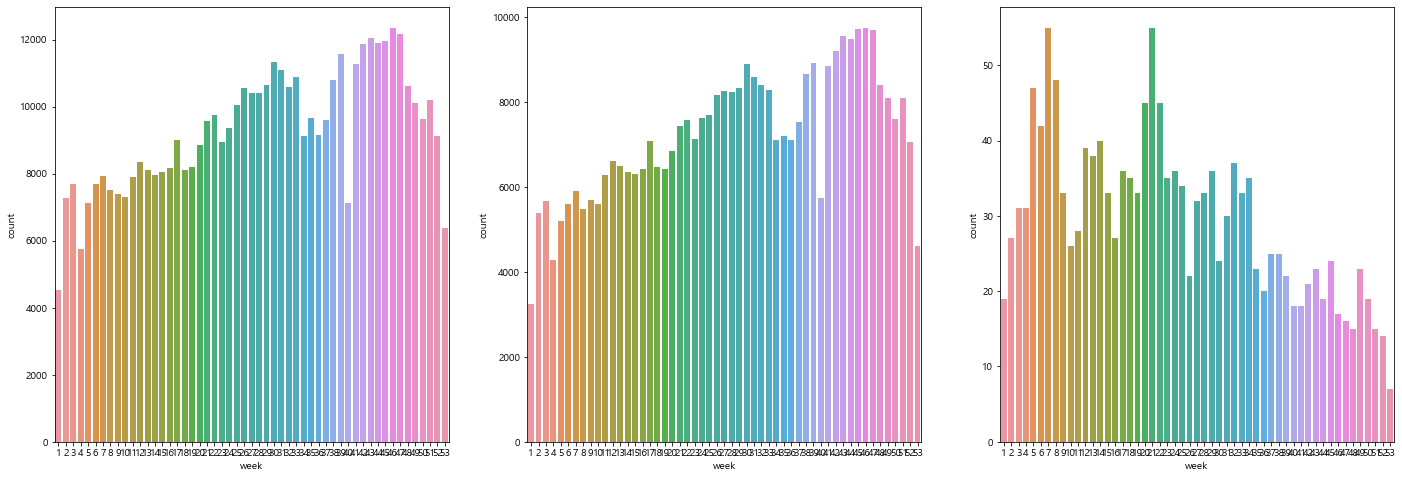

In [89]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(24,8)
sns.countplot(data=adtype, x='week',ax=ax1)
sns.countplot(data=bdtype, x='week',ax=ax2)
sns.countplot(data=cdtype, x='week',ax=ax3)

In [90]:
agtype = df[df['GOODS_TYPE']==0]
bgtype = df[df['GOODS_TYPE']==1]
cgtype = df[df['GOODS_TYPE']==2]
dgtype = df[df['GOODS_TYPE']==3]

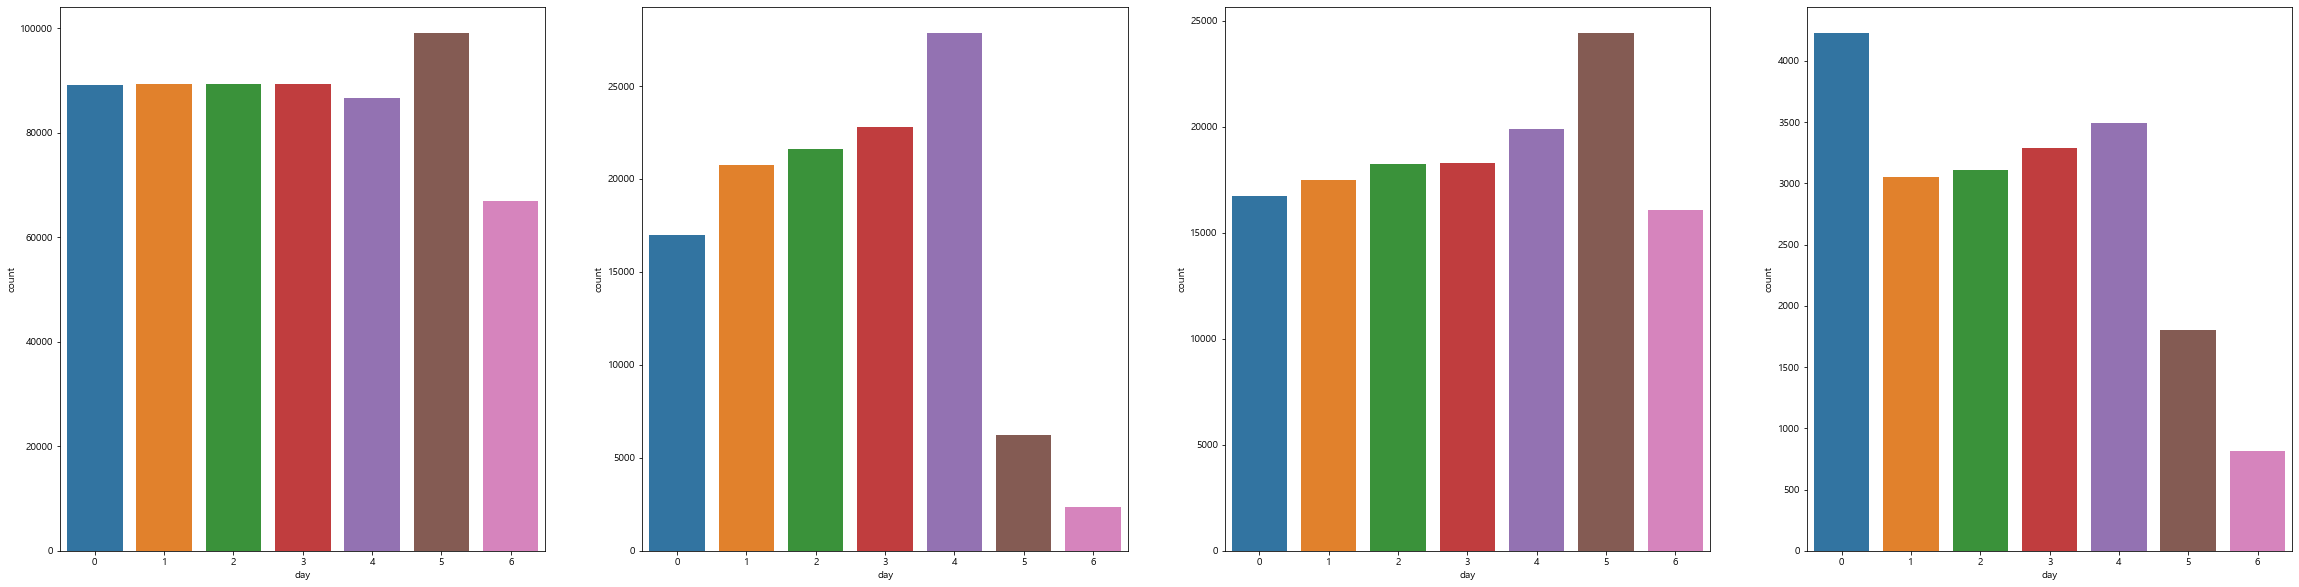

In [91]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(40,10)
sns.countplot(data=agtype, x='day', ax= ax1)
sns.countplot(data=bgtype, x='day', ax= ax2)
sns.countplot(data=cgtype, x='day', ax= ax3)
sns.countplot(data=dgtype, x='day', ax= ax4)

In [92]:
df.corr()

,USER_ID,D_TYPE,STORE_ID,GOODS_TYPE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
USER_ID,1.000000,-0.034839,0.041623,-0.026848,-0.004571,-0.017072,0.222719,0.980679,-0.012200,-0.010817,-0.009436,0.221696,0.222814
D_TYPE,-0.034839,1.000000,0.002826,0.018306,0.049195,-0.003713,0.003980,-0.048647,0.002042,-0.000350,0.000358,0.004178,0.003940
STORE_ID,0.041623,0.002826,1.000000,-0.033986,-0.004013,0.029094,0.056273,0.036709,-0.037532,-0.043609,-0.012362,0.055696,0.056942
GOODS_TYPE,-0.026848,0.018306,-0.033986,1.000000,0.001226,-0.063796,-0.037641,-0.025850,-0.013545,-0.036881,0.003348,-0.037865,-0.037365
COUNT,-0.004571,0.049195,-0.004013,0.001226,1.000000,-0.001853,0.007376,-0.001977,0.003786,0.004417,0.001350,0.007357,0.007300
AD1,-0.017072,-0.003713,0.029094,-0.063796,-0.001853,1.000000,0.024002,-0.014535,-0.009855,-0.010335,-0.003316,0.024172,0.024172
date_int,0.222719,0.003980,0.056273,-0.037641,0.007376,0.024002,1.000000,0.207636,-0.022659,-0.015482,-0.008918,0.996380,0.999825
join_date_int,0.980679,-0.048647,0.036709,-0.025850,-0.001977,-0.014535,0.207636,1.000000,-0.010390,-0.008589,-0.008910,0.206709,0.207707
day,-0.012200,0.002042,-0.037532,-0.013545,0.003786,-0.009855,-0.022659,-0.010390,1.000000,0.757183,0.067380,-0.022241,-0.041370
is_weekend,-0.010817,-0.000350,-0.043609,-0.036881,0.004417,-0.010335,-0.015482,-0.008589,0.757183,1.000000,0.052497,-0.014428,-0.029651


In [93]:
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0,0,11,46
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1,0,11,46
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0,0,11,45
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0,0,11,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0,0,5,22
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0,0,5,22
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0,0,5,22
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0,0,5,22


In [94]:
!python --version

Python 3.8.3


In [95]:
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0,0,11,46
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1,0,11,46
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0,0,11,45
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0,0,11,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0,0,5,22
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0,0,5,22
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0,0,5,22
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0,0,5,22


In [96]:
adf = df[df['D_TYPE']==0]
bdf = df[df['D_TYPE']==1].copy()
cdf = df[df['D_TYPE']==2].copy()

In [97]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493166 entries, 476895 to 879270
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   USER_ID        493166 non-null  int64         
 1   JOIN_DATE      493166 non-null  object        
 2   D_TYPE         493166 non-null  int32         
 3   STORE_ID       493166 non-null  int64         
 4   GOODS_TYPE     493166 non-null  int32         
 5   DATE           493166 non-null  datetime64[ns]
 6   COUNT          493166 non-null  int64         
 7   AD1            493166 non-null  int32         
 8   date_int       493166 non-null  int64         
 9   join_date_int  493166 non-null  int32         
 10  day            493166 non-null  int64         
 11  is_weekend     493166 non-null  int64         
 12  is_holiday     493166 non-null  int64         
 13  month          493166 non-null  int64         
 14  week           493166 non-null  int64         


In [98]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('COUNT', axis=1), df['COUNT'], test_size=0.2, random_state=42)

In [99]:
x_train.drop('DATE', inplace=True, axis=1)
x_test.drop('DATE', inplace=True, axis=1)
x_train.drop('JOIN_DATE', inplace=True, axis=1)
x_test.drop('JOIN_DATE', inplace=True, axis=1)
x_train

,USER_ID,D_TYPE,STORE_ID,GOODS_TYPE,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
331620,646547,1,97327,0,50,163,1203,4,0,0,6,24
112118,689835,1,182296,0,64,62,1258,1,0,0,3,10
823333,1515387,1,109423,0,50,343,2052,2,0,0,12,50
337748,1288524,1,220994,2,53,165,1856,6,1,0,6,24
741775,929509,0,92020,0,52,315,1528,2,0,0,11,46
...,...,...,...,...,...,...,...,...,...,...,...,...
780460,1358287,1,158176,1,64,327,1912,0,0,0,11,48
669871,1664298,1,204949,2,53,291,2220,6,1,0,10,42
494874,1518547,1,91885,0,81,223,2057,1,0,0,8,33
361208,1573156,0,220440,0,53,174,2125,1,0,0,6,26


In [100]:
len(df['USER_ID'].unique())

165425

In [ ]:
!pip install catboost

CatBoost regression

In [101]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor()
cb_model.fit(x_train, y_train)

Learning rate set to 0.125373
0:	learn: 0.4630172	total: 164ms	remaining: 2m 43s
1:	learn: 0.4226331	total: 195ms	remaining: 1m 37s
2:	learn: 0.3884250	total: 227ms	remaining: 1m 15s
3:	learn: 0.3597918	total: 259ms	remaining: 1m 4s
4:	learn: 0.3351821	total: 290ms	remaining: 57.7s
5:	learn: 0.3145258	total: 319ms	remaining: 52.8s
6:	learn: 0.2970724	total: 349ms	remaining: 49.5s
7:	learn: 0.2827970	total: 380ms	remaining: 47.1s
8:	learn: 0.2711501	total: 411ms	remaining: 45.3s
9:	learn: 0.2619939	total: 442ms	remaining: 43.8s
10:	learn: 0.2539570	total: 473ms	remaining: 42.5s
11:	learn: 0.2476916	total: 504ms	remaining: 41.5s
12:	learn: 0.2421780	total: 535ms	remaining: 40.6s
13:	learn: 0.2377475	total: 565ms	remaining: 39.8s
14:	learn: 0.2338386	total: 596ms	remaining: 39.1s
15:	learn: 0.2308206	total: 627ms	remaining: 38.6s
16:	learn: 0.2282795	total: 658ms	remaining: 38.1s
17:	learn: 0.2263437	total: 688ms	remaining: 37.5s
18:	learn: 0.2245924	total: 721ms	remaining: 37.2s
19:	lear

162:	learn: 0.1994306	total: 5.12s	remaining: 26.3s
163:	learn: 0.1993233	total: 5.15s	remaining: 26.3s
164:	learn: 0.1992282	total: 5.18s	remaining: 26.2s
165:	learn: 0.1991368	total: 5.21s	remaining: 26.2s
166:	learn: 0.1991082	total: 5.25s	remaining: 26.2s
167:	learn: 0.1990907	total: 5.28s	remaining: 26.1s
168:	learn: 0.1990653	total: 5.31s	remaining: 26.1s
169:	learn: 0.1989305	total: 5.34s	remaining: 26.1s
170:	learn: 0.1988793	total: 5.37s	remaining: 26s
171:	learn: 0.1988503	total: 5.4s	remaining: 26s
172:	learn: 0.1987733	total: 5.43s	remaining: 26s
173:	learn: 0.1987282	total: 5.46s	remaining: 25.9s
174:	learn: 0.1986761	total: 5.5s	remaining: 25.9s
175:	learn: 0.1986544	total: 5.53s	remaining: 25.9s
176:	learn: 0.1986262	total: 5.56s	remaining: 25.9s
177:	learn: 0.1986104	total: 5.59s	remaining: 25.8s
178:	learn: 0.1984812	total: 5.63s	remaining: 25.8s
179:	learn: 0.1984281	total: 5.66s	remaining: 25.8s
180:	learn: 0.1983828	total: 5.69s	remaining: 25.8s
181:	learn: 0.198296

324:	learn: 0.1924737	total: 10.1s	remaining: 20.9s
325:	learn: 0.1923804	total: 10.1s	remaining: 20.9s
326:	learn: 0.1923422	total: 10.1s	remaining: 20.9s
327:	learn: 0.1922640	total: 10.2s	remaining: 20.8s
328:	learn: 0.1922382	total: 10.2s	remaining: 20.8s
329:	learn: 0.1922086	total: 10.2s	remaining: 20.8s
330:	learn: 0.1922014	total: 10.3s	remaining: 20.8s
331:	learn: 0.1921914	total: 10.3s	remaining: 20.7s
332:	learn: 0.1921878	total: 10.3s	remaining: 20.7s
333:	learn: 0.1921803	total: 10.4s	remaining: 20.7s
334:	learn: 0.1921587	total: 10.4s	remaining: 20.6s
335:	learn: 0.1921011	total: 10.4s	remaining: 20.6s
336:	learn: 0.1920642	total: 10.5s	remaining: 20.6s
337:	learn: 0.1920523	total: 10.5s	remaining: 20.6s
338:	learn: 0.1920353	total: 10.5s	remaining: 20.5s
339:	learn: 0.1920102	total: 10.6s	remaining: 20.5s
340:	learn: 0.1920058	total: 10.6s	remaining: 20.5s
341:	learn: 0.1919907	total: 10.6s	remaining: 20.4s
342:	learn: 0.1918920	total: 10.7s	remaining: 20.4s
343:	learn: 

485:	learn: 0.1879434	total: 15.1s	remaining: 15.9s
486:	learn: 0.1879371	total: 15.1s	remaining: 15.9s
487:	learn: 0.1879258	total: 15.1s	remaining: 15.9s
488:	learn: 0.1879114	total: 15.1s	remaining: 15.8s
489:	learn: 0.1878980	total: 15.2s	remaining: 15.8s
490:	learn: 0.1878223	total: 15.2s	remaining: 15.8s
491:	learn: 0.1878143	total: 15.2s	remaining: 15.7s
492:	learn: 0.1877831	total: 15.3s	remaining: 15.7s
493:	learn: 0.1877283	total: 15.3s	remaining: 15.7s
494:	learn: 0.1876755	total: 15.3s	remaining: 15.6s
495:	learn: 0.1876162	total: 15.4s	remaining: 15.6s
496:	learn: 0.1876120	total: 15.4s	remaining: 15.6s
497:	learn: 0.1875789	total: 15.4s	remaining: 15.6s
498:	learn: 0.1875282	total: 15.5s	remaining: 15.5s
499:	learn: 0.1875253	total: 15.5s	remaining: 15.5s
500:	learn: 0.1874860	total: 15.5s	remaining: 15.5s
501:	learn: 0.1874578	total: 15.6s	remaining: 15.4s
502:	learn: 0.1874299	total: 15.6s	remaining: 15.4s
503:	learn: 0.1874083	total: 15.6s	remaining: 15.4s
504:	learn: 

648:	learn: 0.1843092	total: 20s	remaining: 10.8s
649:	learn: 0.1842914	total: 20s	remaining: 10.8s
650:	learn: 0.1842661	total: 20.1s	remaining: 10.8s
651:	learn: 0.1842634	total: 20.1s	remaining: 10.7s
652:	learn: 0.1842286	total: 20.1s	remaining: 10.7s
653:	learn: 0.1842234	total: 20.2s	remaining: 10.7s
654:	learn: 0.1841743	total: 20.2s	remaining: 10.6s
655:	learn: 0.1841448	total: 20.2s	remaining: 10.6s
656:	learn: 0.1841262	total: 20.3s	remaining: 10.6s
657:	learn: 0.1840745	total: 20.3s	remaining: 10.5s
658:	learn: 0.1840630	total: 20.3s	remaining: 10.5s
659:	learn: 0.1840434	total: 20.3s	remaining: 10.5s
660:	learn: 0.1839963	total: 20.4s	remaining: 10.4s
661:	learn: 0.1839774	total: 20.4s	remaining: 10.4s
662:	learn: 0.1839377	total: 20.4s	remaining: 10.4s
663:	learn: 0.1839316	total: 20.5s	remaining: 10.4s
664:	learn: 0.1839222	total: 20.5s	remaining: 10.3s
665:	learn: 0.1839156	total: 20.5s	remaining: 10.3s
666:	learn: 0.1838717	total: 20.5s	remaining: 10.3s
667:	learn: 0.18

810:	learn: 0.1814397	total: 24.9s	remaining: 5.81s
811:	learn: 0.1814369	total: 25s	remaining: 5.78s
812:	learn: 0.1814255	total: 25s	remaining: 5.75s
813:	learn: 0.1814117	total: 25s	remaining: 5.72s
814:	learn: 0.1814040	total: 25.1s	remaining: 5.69s
815:	learn: 0.1814016	total: 25.1s	remaining: 5.66s
816:	learn: 0.1813973	total: 25.1s	remaining: 5.63s
817:	learn: 0.1813932	total: 25.2s	remaining: 5.6s
818:	learn: 0.1813814	total: 25.2s	remaining: 5.57s
819:	learn: 0.1813395	total: 25.2s	remaining: 5.54s
820:	learn: 0.1813262	total: 25.2s	remaining: 5.5s
821:	learn: 0.1812879	total: 25.3s	remaining: 5.47s
822:	learn: 0.1812737	total: 25.3s	remaining: 5.44s
823:	learn: 0.1812637	total: 25.3s	remaining: 5.41s
824:	learn: 0.1812570	total: 25.4s	remaining: 5.38s
825:	learn: 0.1812455	total: 25.4s	remaining: 5.35s
826:	learn: 0.1812300	total: 25.4s	remaining: 5.32s
827:	learn: 0.1812196	total: 25.5s	remaining: 5.29s
828:	learn: 0.1812109	total: 25.5s	remaining: 5.26s
829:	learn: 0.181194

970:	learn: 0.1790860	total: 29.9s	remaining: 893ms
971:	learn: 0.1790833	total: 29.9s	remaining: 862ms
972:	learn: 0.1790116	total: 30s	remaining: 831ms
973:	learn: 0.1790063	total: 30s	remaining: 801ms
974:	learn: 0.1790008	total: 30s	remaining: 770ms
975:	learn: 0.1789963	total: 30s	remaining: 739ms
976:	learn: 0.1789862	total: 30.1s	remaining: 708ms
977:	learn: 0.1789788	total: 30.1s	remaining: 677ms
978:	learn: 0.1789721	total: 30.1s	remaining: 647ms
979:	learn: 0.1789586	total: 30.2s	remaining: 616ms
980:	learn: 0.1789302	total: 30.2s	remaining: 585ms
981:	learn: 0.1789247	total: 30.2s	remaining: 554ms
982:	learn: 0.1789186	total: 30.3s	remaining: 523ms
983:	learn: 0.1789120	total: 30.3s	remaining: 493ms
984:	learn: 0.1789055	total: 30.3s	remaining: 462ms
985:	learn: 0.1788941	total: 30.4s	remaining: 431ms
986:	learn: 0.1788919	total: 30.4s	remaining: 400ms
987:	learn: 0.1788794	total: 30.4s	remaining: 370ms
988:	learn: 0.1788704	total: 30.5s	remaining: 339ms
989:	learn: 0.178865

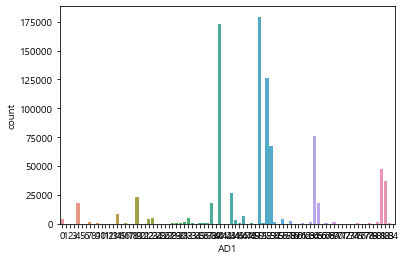

In [121]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols = 2)
sns.countplot(data = df, x='AD1', ax= ax1)
sns.countplot(data = df, x='AD1', ax= ax2)

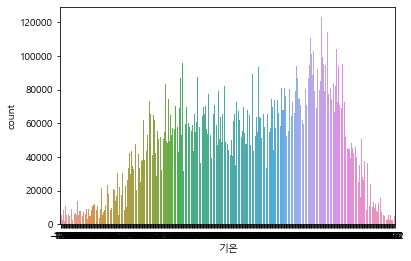

In [123]:
sns.countplot(data=wdf, x='기온')

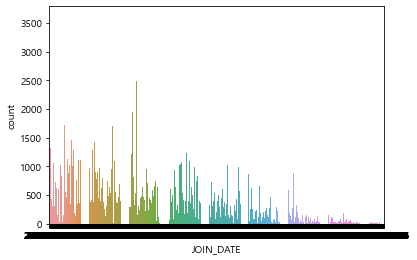

In [130]:
sns.countplot(data=df, x='JOIN_DATE')

In [ ]:
sns.barplot(data=df, x="USER_ID", y = 'D_TYPE')

In [136]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    98820 non-null  datetime64[ns]
 1   지점명     98820 non-null  object        
 2   지점번호    98820 non-null  object        
 3   방향      98820 non-null  object        
 4   구분      98820 non-null  object        
 5   0시      91985 non-null  float64       
 6   1시      91962 non-null  float64       
 7   2시      91960 non-null  float64       
 8   3시      91979 non-null  float64       
 9   4시      91999 non-null  float64       
 10  5시      92036 non-null  float64       
 11  6시      92079 non-null  float64       
 12  7시      92095 non-null  float64       
 13  8시      92081 non-null  float64       
 14  9시      92110 non-null  float64       
 15  10시     92144 non-null  float64       
 16  11시     92100 non-null  float64       
 17  12시     92067 non-null  float64       
 18  13시   

In [141]:
traffic.describe()

,0시,1시,2시,3시,4시,5시,6시,7시,8시,9시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
count,91985.000000,91962.00000,91960.000000,91979.000000,91999.000000,92036.000000,92079.000000,92095.00000,92081.000000,92110.000000,...,92053.000000,92066.000000,92093.000000,92067.000000,92079.000000,92034.000000,92040.000000,92023.000000,91824.000000,91698.000000
mean,738.555232,529.37024,395.721237,334.523598,414.291155,834.110109,1428.291456,1802.42087,1936.528719,1941.244034,...,1993.541210,2016.848641,2063.231722,2084.878621,1993.774096,1806.331019,1654.021262,1578.728633,1341.815713,1004.166438
std,634.131055,460.31075,345.162524,290.982876,370.357027,856.677839,1328.068192,1367.63216,1336.287498,1291.174256,...,1292.560512,1299.166376,1307.331307,1279.334214,1231.266310,1188.160021,1187.374292,1213.158876,1090.351939,853.579108
min,1.000000,0.00000,0.000000,0.000000,1.000000,4.000000,6.000000,7.00000,1.000000,7.000000,...,12.000000,14.000000,11.000000,9.000000,7.000000,9.000000,7.000000,8.000000,6.000000,7.000000
25%,330.000000,228.00000,167.000000,141.000000,181.000000,325.000000,557.000000,791.00000,960.000000,1039.000000,...,1137.000000,1144.000000,1173.000000,1194.000000,1133.000000,985.000000,852.000000,784.000000,634.000000,456.000000
50%,556.000000,397.00000,297.000000,247.000000,303.000000,546.000000,997.000000,1474.00000,1637.000000,1650.000000,...,1693.000000,1707.000000,1748.000000,1778.000000,1714.000000,1513.000000,1338.000000,1252.000000,1025.000000,752.000000
75%,932.000000,680.00000,512.000000,427.000000,500.000000,975.000000,1787.000000,2401.00000,2563.000000,2517.000000,...,2463.000000,2512.000000,2603.000000,2648.000000,2547.000000,2331.000000,2106.000000,1995.000000,1695.000000,1260.000000
max,5717.000000,5274.00000,3359.000000,3752.000000,4328.000000,6924.000000,7896.000000,8324.00000,7931.000000,7549.000000,...,8138.000000,8330.000000,8304.000000,8442.000000,7798.000000,7576.000000,7927.000000,7855.000000,7806.000000,7548.000000


In [142]:
traffic

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98815,2020-12-27,서부간선도로,F-09,유출,목동교->신정교,1310.0,804.0,582.0,473.0,488.0,...,3026.0,2957.0,2799.0,2858.0,2805.0,3031.0,3173.0,2928.0,2278.0,1559.0
98816,2020-12-28,서부간선도로,F-09,유출,목동교->신정교,1030.0,614.0,501.0,565.0,1160.0,...,2925.0,2595.0,2705.0,2264.0,2272.0,2954.0,3081.0,3099.0,2521.0,1837.0
98817,2020-12-29,서부간선도로,F-09,유출,목동교->신정교,1294.0,833.0,582.0,597.0,900.0,...,2634.0,2851.0,2704.0,2163.0,2165.0,2738.0,3054.0,3078.0,2544.0,1952.0
98818,2020-12-30,서부간선도로,F-09,유출,목동교->신정교,1451.0,929.0,616.0,591.0,929.0,...,2901.0,2636.0,2175.0,2036.0,1969.0,2787.0,3058.0,2936.0,2730.0,2160.0


In [144]:
traffic_df = traffic[['DATE','지점명','지점번호','방향','구분']]
traffic_df

,DATE,지점명,지점번호,방향,구분
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역
...,...,...,...,...,...
98815,2020-12-27,서부간선도로,F-09,유출,목동교->신정교
98816,2020-12-28,서부간선도로,F-09,유출,목동교->신정교
98817,2020-12-29,서부간선도로,F-09,유출,목동교->신정교
98818,2020-12-30,서부간선도로,F-09,유출,목동교->신정교


In [146]:
tra = traffic.drop('DATE', axis=1)
tra = tra.drop('지점명', axis=1)
tra = tra.drop('지점번호', axis=1)
tra = tra.drop('방향', axis=1)
tra = tra.drop('구분', axis=1)
tra = tra.T

In [147]:
tra

,0,1,2,3,4,5,6,7,8,9,...,98810,98811,98812,98813,98814,98815,98816,98817,98818,98819
0시,712.0,315.0,632.0,740.0,533.0,359.0,573.0,528.0,615.0,719.0,...,1302.0,1427.0,1459.0,1617.0,1325.0,1310.0,1030.0,1294.0,1451.0,1497.0
1시,645.0,222.0,457.0,518.0,424.0,246.0,434.0,444.0,507.0,522.0,...,850.0,876.0,931.0,1082.0,913.0,804.0,614.0,833.0,929.0,926.0
2시,437.0,186.0,295.0,388.0,297.0,214.0,265.0,288.0,340.0,346.0,...,613.0,642.0,668.0,825.0,627.0,582.0,501.0,582.0,616.0,721.0
3시,309.0,165.0,236.0,331.0,230.0,177.0,227.0,243.0,254.0,267.0,...,656.0,639.0,621.0,671.0,487.0,473.0,565.0,597.0,591.0,540.0
4시,290.0,266.0,279.0,330.0,209.0,277.0,299.0,272.0,321.0,306.0,...,1019.0,1004.0,929.0,810.0,734.0,488.0,1160.0,900.0,929.0,857.0
5시,338.0,716.0,681.0,492.0,302.0,774.0,685.0,658.0,685.0,728.0,...,2284.0,2271.0,2058.0,1366.0,1528.0,745.0,2515.0,2236.0,2067.0,1751.0
6시,504.0,1561.0,1385.0,798.0,525.0,1690.0,1454.0,1434.0,1390.0,1372.0,...,3040.0,3058.0,2683.0,1871.0,2123.0,1224.0,2908.0,3135.0,3099.0,3079.0
7시,574.0,2530.0,2323.0,970.0,731.0,2547.0,2294.0,2368.0,2401.0,2318.0,...,2183.0,2332.0,2514.0,1828.0,2097.0,1472.0,2219.0,2376.0,2509.0,2746.0
8시,853.0,2524.0,2544.0,1369.0,1098.0,2534.0,2528.0,2547.0,2617.0,2591.0,...,1806.0,1971.0,2152.0,2118.0,2649.0,1833.0,1965.0,1952.0,2018.0,2486.0
9시,826.0,2092.0,2115.0,1639.0,1434.0,2150.0,2262.0,2123.0,2253.0,2259.0,...,1327.0,2368.0,2583.0,2534.0,2910.0,2308.0,2386.0,2665.0,2459.0,2716.0


In [153]:
traffic.groupby('DATE')['1시'].value_counts()
# tdf = pd.DataFrame(traffic.groupby('DATE'))
# tdf

DATE        1시    
2020-01-01  236.0     2
            316.0     2
            327.0     2
            389.0     2
            396.0     2
                     ..
2020-12-31  1359.0    1
            1366.0    1
            1397.0    1
            1571.0    1
            1753.0    1
Name: 1시, Length: 81089, dtype: int64

In [109]:
cbr = CatBoostRegressor()
cbr.fit(x_train, y_train,
        eval_set=(x_test, y_test),
        cat_features=['USER_ID','D_TYPE','STORE_ID','GOODS_TYPE','AD1','date_int','join_date_int','day','is_weekend','is_holiday','month','week'],
        use_best_model=True,
        verbose=100)

Learning rate set to 0.159078
0:	learn: 0.4523984	test: 0.4651033	best: 0.4651033 (0)	total: 847ms	remaining: 14m 6s
100:	learn: 0.1862746	test: 0.2086945	best: 0.2083214 (96)	total: 1m 23s	remaining: 12m 21s
200:	learn: 0.1791050	test: 0.2088164	best: 0.2081411 (135)	total: 2m 59s	remaining: 11m 53s
300:	learn: 0.1754912	test: 0.2078823	best: 0.2078823 (300)	total: 4m 40s	remaining: 10m 51s
400:	learn: 0.1727945	test: 0.2076221	best: 0.2075444 (367)	total: 6m 14s	remaining: 9m 18s
500:	learn: 0.1706734	test: 0.2074811	best: 0.2074293 (484)	total: 7m 59s	remaining: 7m 57s
600:	learn: 0.1688326	test: 0.2075870	best: 0.2074103 (562)	total: 9m 41s	remaining: 6m 26s
700:	learn: 0.1673451	test: 0.2082428	best: 0.2074103 (562)	total: 11m 22s	remaining: 4m 51s
800:	learn: 0.1659502	test: 0.2085166	best: 0.2074103 (562)	total: 13m 9s	remaining: 3m 16s
900:	learn: 0.1647959	test: 0.2085642	best: 0.2074103 (562)	total: 15m	remaining: 1m 38s
999:	learn: 0.1637740	test: 0.2085924	best: 0.2074103 (

In [110]:
predict_cbr = cbr.predict(x_test)
predict_cbr

array([1.01253205, 1.01062961, 1.01695334, ..., 1.00599968, 1.01833137,
       1.01520399])

In [113]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
print('CatBoost regression MSE : {}'.format(mean_squared_error(y_test, predict_cbr)))
print('CatBoost regression RMSE : {}'.format(math.sqrt(mean_squared_error(y_test, predict_cbr))))
print('CatBoost regression R2_score : {}'.format(r2_score(y_test, predict_cbr)))


CatBoost regression MSE : 0.04301904495814563
CatBoost regression RMSE : 0.20741032992150038
CatBoost regression R2_score : 0.8424442762126201


In [111]:
predict_cat = cb_model.predict(x_test)
predict_cat

array([1.01215217, 1.0102291 , 1.02188469, ..., 1.01268368, 1.0222903 ,
       1.01613965])

In [114]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
print('CatBoost regression MSE : {}'.format(mean_squared_error(y_test, predict_cat)))
print('CatBoost regression RMSE : {}'.format(math.sqrt(mean_squared_error(y_test, predict_cat))))
print('CatBoost regression R2_score : {}'.format(r2_score(y_test, predict_cat)))


CatBoost regression MSE : 0.04988691817775892
CatBoost regression RMSE : 0.22335379597794822
CatBoost regression R2_score : 0.8172909345461812


Huber Regression

In [82]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor()

In [83]:
huber.fit(x_train,y_train)

HuberRegressor()

In [84]:
predict = huber.predict(x_test)
predict

array([0.88357678, 0.89857758, 0.95114032, ..., 0.93618999, 0.99621854,
       0.99577023])

In [85]:
print('Huber regression MSE :{}'.format(mean_squared_error(y_test, predict)))
print('Huber regression RMSE :{}'.format(math.sqrt(mean_squared_error(y_test, predict))))
# MSE : 0.295460839084915
# RMSE : 0.5435630957717006

Huber regression MSE :0.295460839084915
Huber regression RMSE :0.5435630957717006


XGBoost Regression

In [86]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train)

[13:09:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [87]:
predict_xgb = xgb_model.predict(x_test)

print('XGBoost regression MSE : {}'.format(mean_squared_error(y_test, predict_xgb)))
print('XGBoost regression RMSE : {}'.format(math.sqrt(mean_squared_error(y_test, predict_xgb))))
print('XGBoost regression R2_score : {}'.format(r2_score(y_test, predict_xgb)))


XGBoost regression MSE : 0.05735158127315621
XGBoost regression RMSE : 0.23948190176536557
XGBoost regression R2_score : 0.7899518711623119


In [88]:
predict

array([0.88357678, 0.89857758, 0.95114032, ..., 0.93618999, 0.99621854,
       0.99577023])

In [89]:
predict_xgb

array([1.0142555, 1.0149183, 1.0193212, ..., 1.0192525, 1.0226829,
       1.0192499], dtype=float32)

In [90]:
predict_cat

array([1.01215217, 1.0102291 , 1.02188469, ..., 1.01268368, 1.0222903 ,
       1.01613965])

In [91]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train, y_train)

LGBMRegressor()

In [92]:
predict_lgbm = lgbm_model.predict(x_test)
predict_lgbm

array([1.01467363, 1.01266089, 1.01998882, ..., 1.01673836, 1.02217975,
       1.01636762])

In [93]:
print('LGBM regression MSE : {}'.format(mean_squared_error(y_test, predict_xgb)))
print('LGBM regression RMSE : {}'.format(math.sqrt(mean_squared_error(y_test, predict_xgb))))
print('LGBM regression R2_score : {}'.format(r2_score(y_test, predict_xgb)))


LGBM regression MSE : 0.05735158127315621
LGBM regression RMSE : 0.23948190176536557
LGBM regression R2_score : 0.7899518711623119


In [155]:
xdf = df[['USER_ID', 'COUNT', 'AD1', 'date_int', 'day', 'month', 'week']]
# xdf = adf[['USER_ID', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 'COUNT', 'AD1', 'date_int', 'join_date_int', 'day', 'is_weekend', 'is_holiday', 'month', 'week']]

In [159]:
from pycaret.regression import *
#  categorical_feautres = [] and numerical_features=[]
reg = setup(data=xdf, target='COUNT', categorical_features=['USER_ID', 'AD1', 'date_int', 'day', 'month', 'week'],numeric_imputation='mean',normalize=True, silent=True, train_size=0.8, session_id=6, use_gpu=True, preprocess=False)

,Description,Value
0,session_id,6
1,Target,COUNT
2,Original Data,"(879271, 7)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,6
6,Transformed Train Set,"(703416, 6)"
7,Transformed Test Set,"(175855, 6)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [ ]:
best3_models = compare_models(sort='MSE',n_select=3, fold=5)

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:55:28
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,AdaBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0392,0.0496,0.2225,0.8008,0.0621,0.0277,17.6340
et,Extra Trees Regressor,0.0436,0.0722,0.2682,0.7105,0.0754,0.0309,10.0460
knn,K Neighbors Regressor,0.0379,0.0797,0.2814,0.6858,0.0671,0.0260,3.7160
dt,Decision Tree Regressor,0.0392,0.0864,0.2934,0.6571,0.0818,0.0271,2.9480
lr,Linear Regression,0.0569,0.2572,0.5052,0.0001,0.0786,0.0376,0.7860
ridge,Ridge Regression,0.0569,0.2572,0.5052,0.0001,0.0786,0.0376,0.7640
lar,Least Angle Regression,0.0569,0.2572,0.5052,0.0001,0.0786,0.0376,0.7700
br,Bayesian Ridge,0.0569,0.2572,0.5052,0.0001,0.0786,0.0376,0.8040
lasso,Lasso Regression,0.0569,0.2573,0.5052,-0.0000,0.0786,0.0376,0.7780
en,Elastic Net,0.0569,0.2573,0.5052,-0.0000,0.0786,0.0376,0.7860


In [ ]:
tuned_top3 = [tune_model(i) for i in best3_models]

In [ ]:
blended_1 = blend_models(estimator_list= tuned_top3, fold=5, optimize='MSE')

In [ ]:
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, y_test)